# SNN-ANN hybrid-CIFAR-10

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import utils
from snntorch import surrogate
import numpy as np
import time
import matplotlib.pyplot as plt

# Load CIFAR-10 data and preprocess
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(root='dataset/', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='dataset/', train=False, transform=transform, download=True)

# Parameters
batch_size = 250
input_size = 32  # size of input to first convolutional layer

# Split the dataset
validation_split = 0.2
num_train = len(train_dataset)
num_val = int(num_train * validation_split)
num_train = num_train - num_val

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [num_train, num_val])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Model definition
class HybridSNNANN(nn.Module):
    def __init__(self, beta, thresh, latent_dim, num_steps):
        super(HybridSNNANN, self).__init__()
        self.num_steps = num_steps

        # SNN Encoder
        self.snn_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Conv2d(64, 128, 3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, latent_dim),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True, output=True)
        )

        # ANN Decoder
        self.ann_decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 3, padding=1, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, padding=1, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Reset states
        utils.reset(self.snn_encoder)
        utils.reset(self.ann_decoder)

        # Encode
        spk_rec = []
        mem_rec = []
        for step in range(self.num_steps):
            spk_x, mem_x = self.snn_encoder(x)
            spk_rec.append(spk_x)
            mem_rec.append(mem_x)
        spk_rec = torch.stack(spk_rec, dim=2)
        mem_rec = torch.stack(mem_rec, dim=2)

        # Decode
        decoded_x = []
        for step in range(self.num_steps):
            x_recon = self.ann_decoder(mem_rec[..., step])
            decoded_x.append(x_recon)
        decoded_x = torch.stack(decoded_x, dim=4)

        out = decoded_x[:,:,:,:,-1]
        return out

# Initialize the model
beta = 0.5
thresh = 1.0
latent_dim = 256
num_steps = 10
model = HybridSNNANN(beta, thresh, latent_dim, num_steps)

# Setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()


# Training loop
train_losses = []
val_losses = []
num_epochs = 30
patience = 3
best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)

    val_loss = validate(model, device, val_loader, criterion)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

# ... (same as before, plotting the loss, and testing on the test set)

# ... (same as before, visualization of test set results)


Files already downloaded and verified
Files already downloaded and verified
Epoch 0, Training Loss: 0.2397, Validation Loss: 0.2101
Epoch 1, Training Loss: 0.1902, Validation Loss: 0.1785
Epoch 2, Training Loss: 0.1745, Validation Loss: 0.1701
Epoch 3, Training Loss: 0.1665, Validation Loss: 0.1636
Epoch 4, Training Loss: 0.1628, Validation Loss: 0.1608
Epoch 5, Training Loss: 0.1606, Validation Loss: 0.1603
Epoch 6, Training Loss: 0.1590, Validation Loss: 0.1575
Epoch 7, Training Loss: 0.1579, Validation Loss: 0.1566
Epoch 8, Training Loss: 0.1568, Validation Loss: 0.1561
Epoch 9, Training Loss: 0.1561, Validation Loss: 0.1552
Epoch 10, Training Loss: 0.1555, Validation Loss: 0.1546
Epoch 11, Training Loss: 0.1548, Validation Loss: 0.1539
Epoch 12, Training Loss: 0.1546, Validation Loss: 0.1535
Epoch 13, Training Loss: 0.1539, Validation Loss: 0.1531
Epoch 14, Training Loss: 0.1535, Validation Loss: 0.1529
Epoch 15, Training Loss: 0.1531, Validation Loss: 0.1537
Epoch 16, Training Los

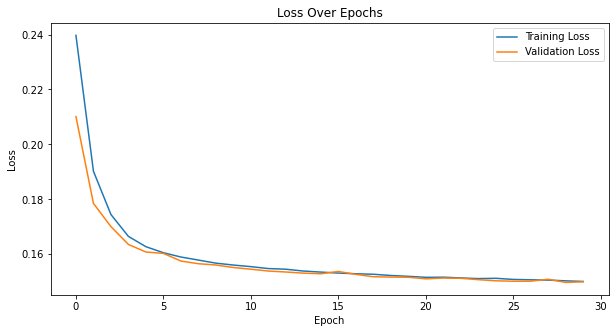

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
# Calculate the average loss for the entire test set
total_loss = 0

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data)
        total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f'Test set: Average loss: {avg_loss:.4f}')

Test set: Average loss: 0.1473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


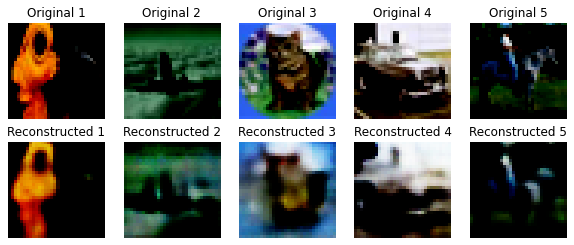

In [11]:
# Plot the first few images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i in range(5):
    # Display original images (assuming they are RGB)
    ax = axes[0, i]
    ax.imshow(images[i].permute(1, 2, 0))  # permute to (H, W, C) for RGB
    ax.set_title(f'Original {i+1}')
    ax.axis('off')

    # Display reconstructed images
    ax = axes[1, i]
    ax.imshow(outputs[i].permute(1, 2, 0))  # permute to (H, W, C) for RGB
    ax.set_title(f'Reconstructed {i+1}')
    ax.axis('off')

plt.show()
